<center>
<p><img src="https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png" width="150">
</p>



<h1>Curso Procesamiento de Lenguaje Natural</h1>

<h3>Transfer learning usando modelos y herramientas de *Hugging Face*</h3>


<p> Julio Waissman Vilanova </p>
<p>
<img src="https://identidadbuho.unison.mx/wp-content/uploads/2019/06/letragrama-cmyk-72.jpg" width="150">
</p>


<a target="_blank" href="https://colab.research.google.com/github/mcd-unison/pln/blob/main/labs/atencion/transfer-hf.ipynb"><img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;"  width="30" /> Ejecuta en Colab</a>

Tomado de [esta libreta](https://colab.research.google.com/github/somosnlp/nlp-de-cero-a-cien/blob/main/4_transformers_aprendizaje_por_transferencia/clasificacion_de_textos.ipynb) pero ajustado para que pueda funcionar con nuevos conjuntos de datos y con los requerimientos necesarios por colab.

</center>


# Clasificación de textos con 🤗 Transformers

> Cómo afinar un modelo de RoBERTa en español para clasificar las reseñas de Amazon.

## Configuración

Si está ejecutando este notebook en Google Colab, ejecute la siguiente celda para instalar las bibliotecas que necesitamos:

In [1]:
!pip install torch==1.13.1
!pip install transformers datasets
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 928.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.13.1 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.13.1 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 1.13.1 wh

Para compartir tu modelo con la comunidad, primero crea una cuenta en el [Hugging Face Hub](https://huggingface.co/join). A continuación, ejecute la siguiente celda y proporcione su nombre de usuario y contraseña para generar un token de autenticación:

In [2]:
# Esto sólo funciona en Google Colab! Para los notebooks normales, es necesario ejecutar esto en el terminal
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) 
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in c

Si no tienes instalado [Git LFS](https://git-lfs.github.com), puedes hacerlo descomentando y ejecutando la celda de abajo:

In [ ]:
# !apt install git-lfs
# !git config --global user.email "you@example.com"
# !git config --global user.name "Your Name"

## Cargar y explorar los datos

Utilizaremos 🤗 Datasets para cargar y procesar nuestro conjunto de datos. Si no está familiarizado con 🤗 Datasets, vea el siguiente vídeo :)

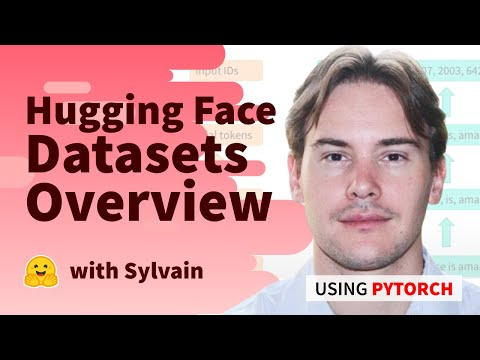

In [3]:
from IPython.display import YouTubeVideo

YouTubeVideo("_BZearw7f0w", width=600, height=400)

In [4]:
from datasets import load_dataset

dataset = load_dataset("tyqiangz/multilingual-sentiments", 'spanish')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1839 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/324 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/870 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 870
    })
})

In [5]:
import random
import pandas as pd
from datasets import ClassLabel
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    "Taken from https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb"

    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(dataset["train"])

,text,source,label
0,que te echo de menos cosa chicaa! http,intertass_2017,negative
1,Ya cambiaron al modelo d Paco Rabane. el que estaba antes era un muñequito yico.,intertass_2017,neutral
2,Como me hace feliz caminar,intertass_2017,positive
3,"@user si si, prendieron fuego !! La única que me sabía la cantaron cuando estaba haciendo fila en el baño 1 gusto conocerte!!",intertass_2017,positive
4,Soy muy poco cariñoso pero el amor esta,intertass_2017,positive
5,"Al parecer tu casita no es tan ""ita""...iSe ve divina chinita @user! Que felicidad por uds. - seguro Dormy tb está re feliz",intertass_2017,positive
6,"voy a salir a comprar mayolicas y acabados a habich, veamos q sucede en el camino, la gente buena celulares prendidos porfavor, 3, 2 ,1",intertass_2017,neutral
7,Sólo la Karlita me entiende y me da buenos consejos,intertass_2017,positive
8,"Llevo como una hora repitiendo ""No debí haber bebido ese último Monster"" teniendo que madrugar Mi vida.",intertass_2017,negative
9,"@user Monsefuana, tienes que configurar eso. Jajajaja. No se puede vivir en paz con el carrete lleno de memes. Te daré los tips.",intertass_2017,neutral


In [6]:
dataset.set_format("pandas")
df = dataset["train"][:]
df.head()

,text,source,label
0,estoy hasta el ojete de que me digáis que teng...,intertass_2017,2
1,@user Por? Tenía pensado verla después de la ...,intertass_2017,1
2,Esto de estar feliz mola,intertass_2017,0
3,Ya no es tan divertido,intertass_2017,2
4,@user te recuerdo que soy una persona que tien...,intertass_2017,1


In [7]:
df["label"].value_counts()

label
2    613
1    613
0    613
Name: count, dtype: int64

In [8]:
df["source"].value_counts()

source
intertass_2017    1839
Name: count, dtype: int64

In [9]:
dataset.reset_format()

In [10]:
def formateado(examples):
    return {"labels": examples['label']}

In [11]:
dataset = dataset.map(formateado)

Map:   0%|          | 0/1839 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

In [12]:
show_random_elements(dataset["train"], num_examples=3)

,text,source,label,labels
0,@user una gran oportunidad para que disfrutemos (con @user ) de su trabajo...,intertass_2017,neutral,1
1,"@user Qué fácil es quedarse calladito, bajarse los pantalones y no decir ni mú... Cuánta ignorancia en tu ""opinión"". Saludos",intertass_2017,negative,2
2,@user vas a ser un gran comunicador,intertass_2017,positive,0


## Tokenizar los textos

In [13]:
from transformers import AutoTokenizer

model_checkpoint = "BSC-TeMU/roberta-base-bne"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

## Tokenización de textos

Para entender la siguiente sección, vea este breve vídeo sobre la tokenización:

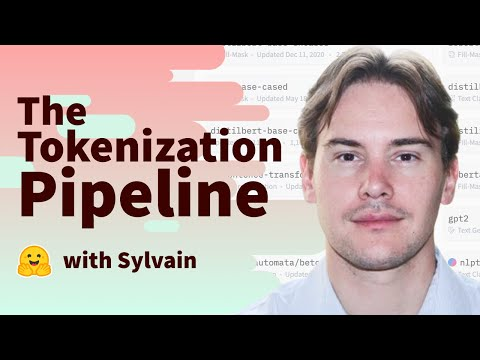

In [14]:
YouTubeVideo("Yffk5aydLzg", width=600, height=400)

In [15]:
tokenizer.vocab_size

50262

In [17]:
text = "¡Hágase la luz; y la luz se hizo!"
tokenized_text = tokenizer.encode(text)

for token in tokenized_text:
    print(token, tokenizer.decode([token]))

0 <s>
1465 ¡
94 H
1578 ág
2533 ase
332  la
2987  luz
81 ;
342  y
332  la
2987  luz
361  se
2570  hizo
55 !
2 </s>


In [18]:
encoded_text = tokenizer(text, return_tensors="pt")
encoded_text

{'input_ids': tensor([[   0, 1465,   94, 1578, 2533,  332, 2987,   81,  342,  332, 2987,  361,
         2570,   55,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [19]:
def tokenize_texts(examples):
    return tokenizer(examples["text"], truncation=True)

In [20]:
columns = dataset["train"].column_names
columns.remove("labels")
encoded_dataset = dataset.map(tokenize_texts, batched=True, remove_columns=columns)
encoded_dataset

Map:   0%|          | 0/1839 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 324
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 870
    })
})

In [21]:
encoded_dataset["train"][0]

{'labels': 2,
 'input_ids': [0,
  31576,
  796,
  344,
  41012,
  343,
  313,
  341,
  503,
  1812,
  5702,
  341,
  2715,
  1611,
  313,
  4549,
  7546,
  2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Cargar el modelo preentrenado

In [22]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at BSC-TeMU/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### De las input IDs a los hidden states

In [23]:
outputs = model(**encoded_text)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0710, -0.0269,  0.0349]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

## Definir las métricas de rendimiento

In [24]:
from datasets import load_metric

metric = load_metric("accuracy")
metric

<ipython-input-24-87016092d90c>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = datasets.load_metric("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
        {'accuracy': 0.5}

   

In [25]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## Afinar el modelo preentrenado

Si quiere entender más profundamente cómo funciona el Entrenador, vea el siguiente vídeo:

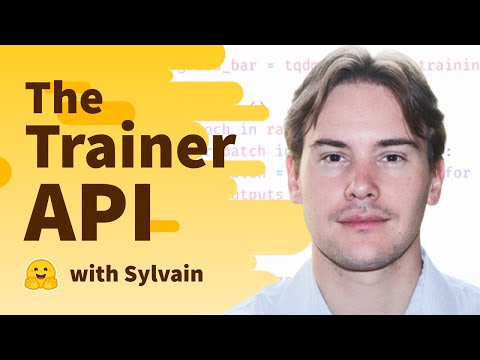

In [26]:
YouTubeVideo("nvBXf7s7vTI", width=600, height=400)

In [27]:
from transformers import TrainingArguments

model_name = model_checkpoint.split("/")[-1]

batch_size = 16
num_train_epochs=2
num_train_samples = 1_839
train_dataset = encoded_dataset["train"].shuffle(seed=42).select(range(num_train_samples))
logging_steps = len(train_dataset) // (2 * batch_size * num_train_epochs)

training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=num_train_epochs,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=logging_steps,
    push_to_hub=True,
    push_to_hub_model_id=f"{model_name}-finetuned-multi-sentiment"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1929: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case enrique2701/roberta-base-bne-finetuned-multi-sentiment).
  warnings.warn(


In [28]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer
)

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.806000,0.740361,0.660494
2,0.588600,0.705659,0.672840


TrainOutput(global_step=230, training_loss=0.7565107666927835, metrics={'train_runtime': 1897.3422, 'train_samples_per_second': 1.939, 'train_steps_per_second': 0.121, 'total_flos': 68850923034726.0, 'train_loss': 0.7565107666927835, 'epoch': 2.0})

## Empuje hacia el Hugging Face Hub

Para más detalles sobre el envío de modelos al Hub, vea el siguiente vídeo:

In [ ]:
YouTubeVideo("A5IWIxsHLUw", width=600, height=400)

In [30]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/enrique2701/roberta-base-bne-finetuned-multi-sentiment/commit/daf112c55467c8927c4be46190718d03ccec2e66', commit_message='End of training', commit_description='', oid='daf112c55467c8927c4be46190718d03ccec2e66', pr_url=None, pr_revision=None, pr_num=None)

## Descargue el modelo desde el Hub

In [31]:
from transformers import pipeline

model_checkpoint = "enrique2701/roberta-base-bne-finetuned-multi-sentiment"
pipe = pipeline("sentiment-analysis", model=model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/937 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

In [32]:
pipe("Tengo sueño - res XD")

[{'label': 'LABEL_1', 'score': 0.7793630361557007}]